In [14]:
import bilby
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [15]:
c=299792458
fstar=c/(2*np.pi*2.5e9)
transfer_data = np.genfromtxt('R.txt')
Rtransfunction=scipy.interpolate.interp1d(transfer_data[:,0]*fstar,transfer_data[:,1],kind='cubic')

def sn(f):
    sa=(3*1e-15)**2
    sx=(1.5*1e-11)**2
    length=2.5e9
    sn11=sx/length**2+2*sa/(2*np.pi*f)**4/length**2*(1+(1e-4/f)**2)*(1+np.cos(2*np.pi*f*length/c)**2)
    return sn11/(Rtransfunction(f)*2)

In [3]:
timelist=np.loadtxt('scalar_timelist_five.txt') 
# window=np.loadtxt('windowa07.txt')
duration=timelist[-1]
sampling_frequency=1/(timelist[1]-timelist[0])
data1=np.loadtxt('scalar_signal_detector1_five.txt')
data2=np.loadtxt('scalar_signal_detector2_five.txt')

In [4]:
plot_parameter_keys=['thetas','phis','theta1','phi1','dl','phi0','mu','M','chi1','d','r0']

In [5]:
plot_parameter_range=[0,1,2,3,4]
plot_parameter_keys=['M','mu','p0','e0','d']

In [6]:
frequency_domain_data1=[]
frequency_domain_data2=[]
fim=np.zeros((len(plot_parameter_range),len(plot_parameter_range)))

for i in plot_parameter_range:
    signalgrt=data1[:,i]
    signal_frequency_domain,freqs=bilby.utils.nfft(time_domain_strain=signalgrt,sampling_frequency=sampling_frequency)
    frequency_mask=(1e-4<freqs)&(freqs<sampling_frequency/2)
    frequency_array=freqs[frequency_mask]
    frequency_domain_data1.append(signal_frequency_domain[frequency_mask])
    
for i in plot_parameter_range:
    signalgrt=data2[:,i]
    signal_frequency_domain,freqs=bilby.utils.nfft(time_domain_strain=signalgrt,sampling_frequency=sampling_frequency)
    frequency_mask=(1e-4<freqs)&(freqs<sampling_frequency/2)
    frequency_array=freqs[frequency_mask]
    frequency_domain_data2.append(signal_frequency_domain[frequency_mask])
    
    
frequency_domain_data1=np.array(frequency_domain_data1)
frequency_domain_data2=np.array(frequency_domain_data2)
power_spectral_density=sn(frequency_array)
for i in range(len(plot_parameter_range)):
    for j in range(len(plot_parameter_range)):
        fim1ij=bilby.gw.utils.noise_weighted_inner_product(frequency_domain_data1[i,:],frequency_domain_data1[j,:],
                                                               power_spectral_density=power_spectral_density,duration=duration)
        fim2ij=bilby.gw.utils.noise_weighted_inner_product(frequency_domain_data2[i,:],frequency_domain_data2[j,:],
                                                               power_spectral_density=power_spectral_density,duration=duration)

        fim[i,j]=fim1ij.real+fim2ij.real
gamma=np.linalg.inv(fim)
for i in range(len(plot_parameter_range)):
    print(np.sqrt(gamma[i,i]))

6.26780700298263
0.0011835976444743365
1.3564321971199082e-05
1.956868815013119e-05
0.003418815834854178


In [7]:
fim

array([[ 6.93502426e+02, -1.12221258e+07,  1.40114212e+08,
         1.33367576e+08, -4.81988893e+06],
       [-1.12221258e+07,  1.94872204e+11, -2.32082970e+12,
        -2.01896015e+12,  8.34818258e+10],
       [ 1.40114212e+08, -2.32082970e+12,  2.85675806e+13,
         2.63942375e+13, -9.96032669e+11],
       [ 1.33367576e+08, -2.01896015e+12,  2.63942375e+13,
         2.71217985e+13, -8.69358540e+11],
       [-4.81988893e+06,  8.34818258e+10, -9.96032669e+11,
        -8.69358540e+11,  3.57669574e+10]])

In [8]:
# fim=np.array([[ 6.97760337e+02, -1.13260012e+07,  1.41164959e+08,
#          1.33772073e+08, -4.86765133e+05],
#        [-1.13260012e+07,  1.97526100e+11, -2.34655891e+12,
#         -2.02836880e+12,  8.46680640e+09],
#        [ 1.41164959e+08, -2.34655891e+12,  2.88253453e+13,
#          2.64968435e+13, -1.00770004e+11],
#        [ 1.33772073e+08, -2.02836880e+12,  2.64968435e+13,
#          2.71565484e+13, -8.74047550e+10],
#        [-4.86765133e+05,  8.46680640e+09, -1.00770004e+11,
#         -8.74047550e+10,  3.62971423e+08]])
# gamma=np.linalg.inv(fim)

In [9]:
gamma[3,4]/np.sqrt(gamma[3,3]*gamma[4,4])

-0.893361798110588

In [23]:
cov=gamma[[0,1,3,4],:]
cov=cov[:,[0,1,3,4]]
dim = len(cov)
mean = np.zeros(dim)
Y = np.random.multivariate_normal(mean, cov, 100000)
import corner
from collections import OrderedDict, namedtuple
# plt.rc('text', usetex=True)
plt.rc('font', family='calibri')
def get_median_and_error_bar(key, fmt='.6f',quantiles=(0.16, 0.84)):
    summary = namedtuple('summary', ['median', 'lower', 'upper', 'string'])

    quants_to_compute = np.array([quantiles[0], 0.5, quantiles[1]])
    quants = np.percentile(Y[key], quants_to_compute * 100)
    summary.median =0# quants[1]
    summary.plus =np.sqrt(cov[key,key])# quants[2] - summary.median
    summary.minus =np.sqrt(cov[key,key])# summary.median - quants[0]

    fmt = "{{0:{0}}}".format(fmt).format
    string_template = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    summary.string = string_template.format(
        fmt(summary.median), fmt(summary.minus), fmt(summary.plus))
    return summary
def safe_save_figure(fig, filename, **kwargs):
    from matplotlib import rcParams
    try:
        fig.savefig(fname=filename, **kwargs)
    except RuntimeError:
        logger.debug(
            "Failed to save plot with tex labels turning off tex."
        )
        rcParams["text.usetex"] = False
        fig.savefig(fname=filename, **kwargs)

In [24]:
defaults_kwargs = dict(
    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16), color='#0072C1',
    truth_color='tab:orange', quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False, plot_datapoints=True, fill_contours=True,
    max_n_ticks=3)

defaults_kwargs['hist_kwargs'] = dict(density=True)
# if 'lionize' in kwargs and kwargs['lionize'] is True:
#     defaults_kwargs['truth_color'] = 'tab:blue'
#     defaults_kwargs['color'] = '#FF8C00'
# defaults_kwargs.update(kwargs)
kwargs = defaults_kwargs

# kwargs['truths'] =[]

In [25]:
plot_parameter_keys=['M','mu','e0','d']
kwargs['labels']=[r'$\Delta M$',r'$\Delta m_p$',r'$\Delta e_0$',r'$\Delta d$']
kwargs['quantiles']=(0.16, 0.84)

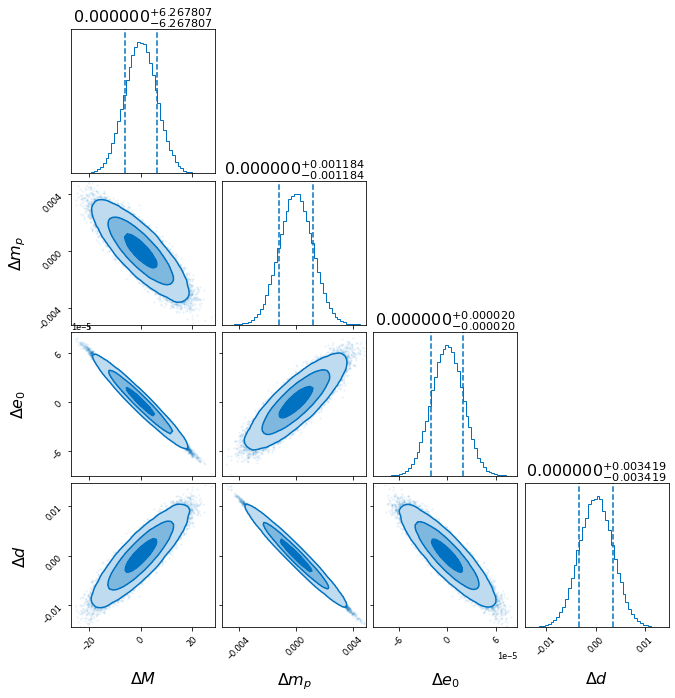

In [27]:
fig=corner.corner(Y,**kwargs)
axes = fig.get_axes()
for i, par in enumerate(plot_parameter_keys):
    ax = axes[i + i * len(plot_parameter_keys)]
    if ax.title.get_text() == '':
        ax.set_title(get_median_and_error_bar(i, quantiles=kwargs['quantiles']).string,
            **kwargs['title_kwargs'])
filename = 'cornere02.pdf'
safe_save_figure(fig=fig, filename=filename, dpi=300)
# plt.close(fig)